In [21]:
import numpy
import pandas as pd
import torch
import numpy as np
#from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os,random
import torchvision.transforms as T
import csv
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

#my imports

import train

from torch.utils.tensorboard import SummaryWriter #tensorboard --logdir log --bind_all


In [36]:
import os
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2

# Custom transform for adding Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'
    
# Data augmentation transform
augment_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.1),
])

# Original transform
original_transform = transforms.Compose([
    transforms.ToTensor(),
])

def generate_augmented_dataset(dir, csv_file, augment_times=5):
    pathDir = os.listdir(dir)
    filenumber = len(pathDir)
    sample = random.sample(pathDir, filenumber)
    
    file = pd.read_csv(csv_file)
    file = np.array(file)
    labels = []
    flow_data = []

    def classify_force(force):
        return min((force // 10), 23)

    def calculate_optical_flow(img1, img2):
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        
        # Lucas-Kanade光流参数
        lk_params = dict(winSize=(5, 5), maxLevel=1, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.02))
        
        # 寻找初始关键点
        feature_params = dict(maxCorners=5000, qualityLevel=0.1, minDistance=10, blockSize=2)
        p0 = cv2.goodFeaturesToTrack(img1_gray, mask=None, **feature_params)
        
        # 计算光流
        p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
        
        # 选择好的点
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        
        # 计算光流矢量
        flow_vectors = good_new - good_old  # shape: (N, 2)
        flow_vectors = flow_vectors.flatten()  # 展平为一维数组
        
        return flow_vectors

    for file_name in sample:
        if file_name != "Thumbs.db":
            if int(file_name[-9:-4]) > 2097 and int(file_name[-9:-4]) < 3597:
                img_dir = os.path.join(dir, file_name)
                img = cv2.imread(img_dir)
                ref_img = cv2.imread('database/202404-inkan/output-resize/DSC02098.JPG')
                
                flow_vectors = calculate_optical_flow(ref_img, img)
                
                for _ in range(augment_times):
                    noisy_flow = augment_transform(flow_vectors)
                    flow_data.append(noisy_flow)

                flow_vectors = original_transform(flow_vectors)
                flow_data.append(flow_vectors)
                
                for item in file:
                    sh = item[1]
                    if file_name[-9:-4] == sh[-9:-4]:
                        force = item[0]
                        label = classify_force(force)
                        labels.extend([label] * (augment_times + 1))
    
    labels = torch.tensor(labels, dtype=torch.long)
    return flow_data, labels

class FlowDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        flow = self.data[index]
        label = self.labels[index]
        return torch.tensor(flow, dtype=torch.float32), label

    def __len__(self):
        return len(self.data)

traindir = 'database/202404-inkan/output-resize/'
validdir = 'database/202404-inkan/valid-or/'
csv_file = './label/AI-bolt-color-202404-inkan.csv'

train_rdata, train_label = generate_augmented_dataset(traindir, csv_file, augment_times=2)
valid_rdata, valid_label = generate_augmented_dataset(validdir, csv_file, augment_times=2)

train_data = FlowDataset(train_rdata, train_label)
valid_data = FlowDataset(valid_rdata, valid_label)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=True)


/tmp/ipykernel_1596670/1054775653.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_flow = augment_transform(torch.tensor(flow_vectors))
/tmp/ipykernel_1596670/1054775653.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_flow = augment_transform(torch.tensor(flow_vectors))


In [38]:
print(len(train_rdata), len(train_label))
print(len(valid_rdata), len(valid_label))
dataiter=iter(train_loader)
images, labels = dataiter.__next__()
print(images.shape)
print(labels.shape)
print(images)
print(labels)


3582 3582
915 915
torch.Size([2, 7414])
torch.Size([2])
tensor([[-3.0364, -0.0982, -2.6316,  ..., -0.1360, -1.7650, -6.4902],
        [-4.1116, -6.0159,  0.2132,  ...,  7.6126,  6.1718, -0.9843]])
tensor([21,  7])


/tmp/ipykernel_1596670/1054775653.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(flow, dtype=torch.float32), label


In [41]:
import torch.nn as nn
import torch.optim as optim

# 定义分类模型
class DeepNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DeepNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.output(out)
        return out

In [ ]:

# 训练模型
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        writer.add_scalar('Loss/train', running_loss/len(train_loader), epoch)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 验证模型
def validate_model(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    print(f'Validation Loss: {running_loss/len(valid_loader):.4f}')

casename='202406-1d-flow'

def create_case_folder(case_name):
    if not os.path.exists(case_name):
        os.makedirs(case_name)

create_case_folder("./log/"+casename)
create_case_folder("./result/"+casename)
writer = SummaryWriter("./log/"+casename) #tensorboard

In [ ]:
# 超参数
input_size = 7414  # 假设有1000个角点，每个角点有两个值
num_classes = 24
num_epochs = 200
learning_rate = 0.0001

# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 模型、损失函数和优化器
model = DeepNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
train_model(model, train_loader, criterion, optimizer, num_epochs)
validate_model(model, valid_loader, criterion)

/tmp/ipykernel_1596670/1054775653.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(flow, dtype=torch.float32), label


Epoch [1/200], Loss: 3.1441
Epoch [2/200], Loss: 3.0792
Epoch [3/200], Loss: 3.0722
Epoch [4/200], Loss: 3.0349
Epoch [5/200], Loss: 3.0294
Epoch [6/200], Loss: 3.0243
Epoch [7/200], Loss: 3.0153
Epoch [8/200], Loss: 3.0075
Epoch [9/200], Loss: 3.0074
Epoch [10/200], Loss: 3.0170
Epoch [11/200], Loss: 3.0073
Epoch [12/200], Loss: 3.0086
Epoch [13/200], Loss: 2.9947
Epoch [14/200], Loss: 2.9938
Epoch [15/200], Loss: 2.9961
Epoch [16/200], Loss: 2.9930
Epoch [17/200], Loss: 2.9923
Epoch [18/200], Loss: 2.9893
Epoch [19/200], Loss: 2.9888
Epoch [20/200], Loss: 2.9919
Epoch [21/200], Loss: 2.9865
Epoch [22/200], Loss: 2.9828
Epoch [23/200], Loss: 2.9845
Epoch [24/200], Loss: 2.9812
Epoch [25/200], Loss: 2.9829
Epoch [26/200], Loss: 2.9779
Epoch [27/200], Loss: 2.9772
Epoch [28/200], Loss: 2.9838
Epoch [29/200], Loss: 2.9799
Epoch [30/200], Loss: 2.9781
Epoch [31/200], Loss: 2.9697
Epoch [32/200], Loss: 2.9769
Epoch [33/200], Loss: 2.9750
Epoch [34/200], Loss: 2.9753
Epoch [35/200], Loss: 2

Validation Loss: 12.4995
Accuracy: 0.2372
Precision: 0.2819
Recall: 0.2372
F1 Score: 0.2263

Classification Report:
               precision    recall  f1-score   support

        0-10       0.00      0.00      0.00         0
       10-20       0.00      0.00      0.00         0
       20-30       0.00      0.00      0.00         0
       30-40       0.00      0.00      0.00        12
       40-50       0.52      0.20      0.29        66
       50-60       0.09      0.31      0.14        39
       60-70       0.06      0.08      0.07        36
       70-80       0.48      0.25      0.33        60
       80-90       0.23      0.21      0.22        42
      90-100       0.09      0.21      0.12        24
     100-110       0.19      0.12      0.14        51
     110-120       0.00      0.00      0.00        33
     120-130       0.19      0.20      0.20        30
     130-140       0.00      0.00      0.00        27
     140-150       0.00      0.00      0.00        30
     150-160      

/home/br-python/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/br-python/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/br-python/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/ho

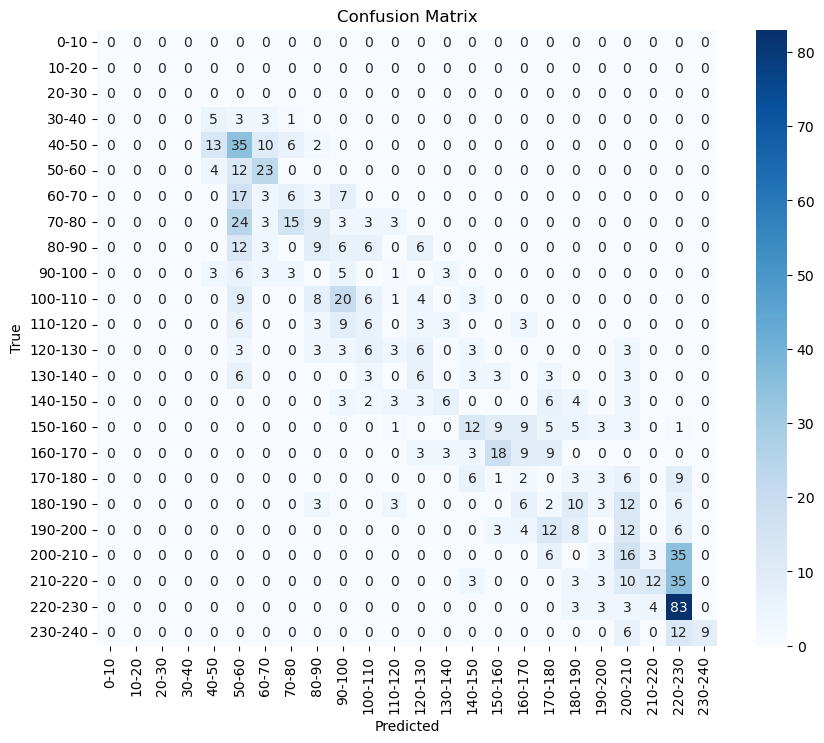

(0.2371584699453552,
 0.28190843576404395,
 0.2371584699453552,
 0.22625558167434626,
 array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  5,  3,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 13, 35, 10,  6,  2,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  4, 12, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 17,  3,  6,  3,  7,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 24,  3, 15,  9,  3,  3,  3,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,

In [28]:
validate_model(model, valid_loader, criterion)

def validate_model(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    print(f'Validation Loss: {running_loss/len(valid_loader):.4f}')

def valid(model, valid_loader, classes):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 计算各项指标
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', labels=np.arange(24))
    recall = recall_score(all_labels, all_predictions, average='weighted', labels=np.arange(24))
    f1 = f1_score(all_labels, all_predictions, average='weighted', labels=np.arange(24))
    conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(24))
    class_report = classification_report(all_labels, all_predictions, target_names=classes, labels=np.arange(24))

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:\n', class_report)

    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1, conf_matrix, class_report

classes = [f'{i*10}-{i*10+10}' for i in range(24)]
valid(model, valid_loader, classes)